In [ ]:
!pip install scipy==1.9.3 --force-reinstall

In [47]:
# import scipy
# def derivative(func, x0, dx=1e-6, n=1, order=3):
#     if n != 1 or order != 3:
#         raise NotImplementedError("Only n=1 and order=3 supported")
#     return (func(x0 + dx) - func(x0 - dx)) / (2 * dx)

# scipy.misc.derivative = derivative

import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from ADRpy import atmospheres as at
from importlib import reload
import helper_functions
helper_functions = reload(helper_functions)
from helper_functions import *
import specs
specs = reload(specs)
from specs import *
import airfoil_functions
airfoil_functions = reload(airfoil_functions)
from airfoil_functions import *
from airfoils import Airfoil

In [2]:
foil = Airfoil.NACA4('2412')
x,y = foil.all_points

foil_vt = Airfoil.NACA4('0012')
x_vt,y_vt = foil_vt.all_points

In [3]:
# Reynolds_numbers = [calculate_reynolds_number(80, 1, 0), calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = list(range(-15,30,1))  # degrees
# phases = ["takeoff", "cruise"]  # one per Re
# Reynolds_numbers = [calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = [29]  # degrees
# phases = ["cruise"]  # one per Re

# get_airfoil_params_with_flap_effect_naca(
#     airfoil_name="2412",
#     Reynolds_numbers=Reynolds_numbers,
#     deflection_angles=deflection_angles,
#     phases=phases
# )

In [4]:
deflections_dict = {}
deflection_angles = list(range(-15,31,1))  # degrees
phases = ["takeoff", "cruise"]  # one per Re
for def_angle in deflection_angles:
    for phase in phases:

        deflections_dict[f"{phase}_{def_angle}"] = load_xfoil_polar(f'ht_deflections/NACA2412_def ({def_angle} deg)_{phase}.plr')


In [5]:
# airfoil_coeffs_vs_alpha = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(200, 1, 3000))}.dat')
# airfoil_coeffs_vs_alpha_to = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(80, 1, 0))}.dat')
airfoil_coeffs_vs_alpha_vt = load_xfoil_polar(f'NACA 0012-{int(calculate_reynolds_number(200, 1, 3000))}.dat')



In [6]:
def relax(old, new, lam=0.25):
    return (1.0 - lam)*old + lam*new



def key_error(curr, prev, key, target_error, eps=1e-9):

    
    ABS_TOL = {
        "cruiseout_static_margin":   target_error/10,
        "loiter_static_margin":      target_error/10,
        "cruiseback_static_margin":  target_error/10,   # << key fix
        "cruiseout_cl":              target_error/100,
        "loiter_cl":                 target_error/100,
        "cruiseback_cl":             target_error/100,
        # add more if needed
    }
    REL_TOL = target_error  # 2% for most quantities

    # hybrid: absolute OR relative

    
    abs_err = abs(curr - prev)
    rel_den = max(abs(prev), eps)#, 1.0 if key.endswith("_static_margin") else eps)
    rel_err = abs_err / rel_den
    # accept if either test passes
    # if key in ABS_TOL:
    #     return abs_err
    # else:
    return rel_err
    
def aitken(x0,x1,x2):

    if (x1 - x0)*(x2 - x1) >= 0:
        return relax(x1, x2, 1)
    
    num = (x2-x1)**2
    den = x2- 2*x1 + x0

    x_aitken = x2 - num/(den if den != 0 else 1e-9)
        
    return x_aitken



    

In [27]:
def debug_pitch_moment_balance(cur, assumed_and_set, hard, phase, deflections_dict):

    if ("cruise" in phase) or (phase == "loiter"):
        phase_for_delta = "cruise"
        rho = get_air_density(hard["cruise_altitude_m"])
    elif phase in ["takeoff", "landing"]:
        phase_for_delta = "takeoff"
        rho = get_air_density(0.0)
    else:
        phase_for_delta = "cruise"
        rho = get_air_density(hard["cruise_altitude_m"])


    # Geometry/kinematics
    c   = cur["chord_m"]
    Sw  = cur["wing_area_m2"]
    St  = cur["horizontal_tail_area_m2"]
    V   = kmh_to_ms(cur[f"{phase}_speed_kmh"])
    rho = get_air_density(hard["cruise_altitude_m"])
    q   = 0.5*rho*V*V
    qt  = q * cur.get("tail_dynamic_pressure_ratio", 1.0)

    x_cg   = cur[f"{phase}_cg_from_nose_m"]
    x_ac_w = cur["wing_le_position_m"] + 0.25*c
    x_ac_t = cur["x_ht_le_m"] + 0.25*cur["h_tail_chord_m"]
    l_t    = x_ac_t - x_cg

    # Wing CL and Cm from polar at current AoA
    CLw = cur[f"{phase}_cl"]
    row = get_row_for_cl(deflections_dict["cruise_0"], CLw)  # or phase-appropriate table
    Cmw = float(row["CM"])   # about wing c/4 (standard XFOIL output)

    lever = (x_ac_w - x_cg)/c
    Cm_from_wing_lift = CLw * lever

    # Thrust offset term (set z offsets if known)
    T = (cur.get(f"{phase}_power_kw", 0.0)*1000.0) / max(V,1.0)
    zT = cur['fuselage_body_height_m'] / 2
    zG = cur.get(f"{phase}_cg_from_floor_m", 0.0)
    Cm_thrust = T*(zT - zG)/(q*Sw*c)
    # print('debug',Cm_thrust)
    # Required tail CL from balance (no guessing)
    CLt_required = - (Cmw + Cm_from_wing_lift + Cm_thrust) * (q/qt) * (Sw/St) * (c/max(l_t,1e-6))

    i_w   = float(assumed_and_set.get("wing_incident_angle", 0.0))
    i_h   = float(assumed_and_set.get("ht_incident_angle",   0.0))
    deda  = float(assumed_and_set.get("ht_downwash_efficiency_coeff", 0.3))  # dε/dα
    eta_h = cur.get(f"{phase}_tail_dynamic_pressure_ratio", 1.0)  
    row_w   = get_row_for_cl(deflections_dict[f"{phase_for_delta}_0"], CLw)
    alpha_w = float(row_w["alpha"]) - i_w
    Cm_w    = float(row_w["CM"])
    alpha_t = (1.0 - deda) * alpha_w + i_h

    delta_e = solve_delta_e_for_CLt(CLt_required, alpha_t, deflections_dict, phase=phase_for_delta)
    return {
        "CLw": CLw,
        "Cmw": Cmw,
        "lever_c": lever,
        "Cm_wing_lift": Cm_from_wing_lift,
        "Cm_thrust": Cm_thrust,
        "l_t_m": l_t,
        "CLt_required": CLt_required,
        "note": "Nose-up positive convention"
    }


In [58]:
def refine_design_from_iterable_constraints(
    hard_constraints, assumed_and_set, weights_dict_kg_no_fuel,
    iterable_constraints, deflections_dict,
    target_error=0.02, max_iterations=10
):
    g = 9.81
    cur  = iterable_constraints.copy()
    prev = iterable_constraints.copy()
    aitken_values = iterable_constraints.copy()
    
    for i in range(max_iterations):
        # ------------------------------
        # 0) Atmosphere & phase speeds
        # ------------------------------
        rho   = get_air_density(hard_constraints["cruise_altitude_m"])
        Vc_ms = kmh_to_ms(cur["cruiseout_speed_kmh"])
        Vl_ms = kmh_to_ms(cur["loiter_speed_kmh"])
        Vb_ms = kmh_to_ms(cur["cruiseback_speed_kmh"])

        if (cur["cruiseout_static_margin"] > 0.2) or (cur['cruiseback_static_margin'] > 0.1):
            assumed_and_set['wing_le_position_fuselage_length_coeff'] -= 0.01
        if (cur["cruiseout_static_margin"] < 0.1) or (cur['cruiseback_static_margin'] < 0.03):
            assumed_and_set['wing_le_position_fuselage_length_coeff'] += 0.01
        # ---------------------------------------------------------
        # 1) GEOMETRY (wing/tail/fuselage) — fuselage sizing FIRST
        # ---------------------------------------------------------
        # Wing geometry (use the current wing area; will be refreshed at end of iter)
        
        cur["wing_span_m"] = np.sqrt(cur["wing_area_m2"] * assumed_and_set["aspect_ratio"])
        cur["chord_m"]     = cur["wing_area_m2"] / cur["wing_span_m"]

        # Geometric tail arm (fixed AC→AC; do NOT tie to moving wing AC)
        cur["tail_arm_m"] = assumed_and_set["horizontal_tail_arm_mac_coeff"] * cur["chord_m"]
        

        # Fuselage main length from your sizing model (do this BEFORE masses & CGs)
        cur["fuselage_body_length_m"] = initial_size_fuselage(hard_constraints, assumed_and_set, cur, False)
        # 
        

        # Wing LE station as a fraction of fuselage length (geometry placement)
        cur["wing_le_position_m"] = assumed_and_set["wing_le_position_fuselage_length_coeff"] * cur["fuselage_body_length_m"]

        # cur["tail_arm_m"] = cur["fuselage_body_length_m"] * 0.9 - (cur['wing_le_position_m'] + 0.25*cur["chord_m"])

        # Tail areas from volume coefficients (use current tail arm)
        cur["horizontal_tail_area_m2"] = (
            assumed_and_set["horizontal_tail_volume_coefficient"]
            * (cur["wing_area_m2"] * cur["chord_m"]) / cur["tail_arm_m"]
        )
        cur["vertical_tail_area_m2"] = (
            assumed_and_set["vertical_tail_volume_coefficient"]
            * (cur["wing_area_m2"] * cur["wing_span_m"]) / cur["tail_arm_m"]
        )

        # Tail planform geometry from areas + AR
        cur["h_tail_span_m"], cur["h_tail_chord_m"] = tail_geometry(cur["horizontal_tail_area_m2"], assumed_and_set["AR_horizontal"])
        cur["v_tail_span_m"], cur["v_tail_chord_m"] = tail_geometry(cur["vertical_tail_area_m2"],   assumed_and_set["AR_vertical"])

        cur["x_ht_le_m"] = cur["wing_le_position_m"] + 0.25*cur["chord_m"] + cur["tail_arm_m"] - 0.25*cur["h_tail_chord_m"]
        # -----------------------------------------
        # 2) STRUCTURAL MASSES (per-item components)
        # -----------------------------------------
        # Fuselage mass (depends on sized fuselage geometry)
        fuselage_mass = get_fuselage_mass(
            cur["fuselage_body_length_m"],
            cur["fuselage_body_width_m"],
            cur["fuselage_body_height_m"],
            assumed_and_set
        ) * assumed_and_set["fuselage_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"] * cur["fuselage_body_length_m"] * 2 * (cur["fuselage_body_height_m"] + cur["fuselage_body_width_m"])

        weights_dict_kg_no_fuel["fuselage"] = fuselage_mass

        
        wing_mass = get_wing_or_tail_mass(
            cur["wing_area_m2"], assumed_and_set, "wing"
        ) * assumed_and_set["wing_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"]*(2*cur["wing_area_m2"])

        weights_dict_kg_no_fuel["wing"] = wing_mass


        htail_mass = get_wing_or_tail_mass(
            cur["horizontal_tail_area_m2"], assumed_and_set, "tail"
        ) * assumed_and_set["tail_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"]*(2*cur["horizontal_tail_area_m2"])


        vtail_mass = get_wing_or_tail_mass(
            cur["vertical_tail_area_m2"], assumed_and_set, "tail"
        ) * assumed_and_set["tail_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"]*(2*cur["vertical_tail_area_m2"])

        weights_dict_kg_no_fuel["horizontal_tail"] = htail_mass
        weights_dict_kg_no_fuel["vertical_tail"]   = vtail_mass
        weights_dict_kg_no_fuel["tails"]           = htail_mass + vtail_mass  # if you still use a combined key

        # ------------------------------------------------
        # 3) FUEL CAPACITY & DISTRIBUTION (by geometry)
        # ------------------------------------------------
        # Fuselage tank capacity from sized cross-section and your tank length
        fus_cs_area = (
            (cur["fuselage_body_width_m"]  - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02) *
            (cur["fuselage_body_height_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02)
        )
        fus_tank_vol_m3 = assumed_and_set["fuselage_fuel_tank_length"] * fus_cs_area
        fus_tank_cap_kg = fus_tank_vol_m3 * 1000.0 * assumed_and_set["fuel_density_kgL"]

        # Wing tank capacity from your helper (uses current wing geometry)
        wing_tank_vol_m3 = wing_fuel_tank_volume("naca2412_coords.dat", cur, 0.25, 0.65)

        # Fuel from previous iteration (or initial seed)
        fuel_total = cur.get("fuel_kg", 0.0)

        # Split: fill fuselage first, rest to wing
        fus_fuel_kg  = min(fuel_total, fus_tank_cap_kg)
        wing_fuel_kg = max(0.0, fuel_total - fus_fuel_kg)

        # ------------------------------------------
        # 4) COMPONENT POSITIONS (for CG calculation)
        # ------------------------------------------
        comp_x, comp_z = estimate_component_positions(cur, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel, internal_payload_x=cur["cruiseout_cg_from_nose_m"])

        # ==========================================
        # 5) PHASES (CG → NP → TRIM → DRAG/POWER)
        # ==========================================

        # ---------- CRUISE OUT ----------
        wts_c = weights_dict_kg_no_fuel.copy()
        wts_c["fuselage_fuel"] = fus_fuel_kg
        wts_c["wing_fuel"]     = wing_fuel_kg
        cur["cruiseout_mass_kg"] = sum(wts_c.values())

        cur["cruiseout_cg_from_nose_m"]  = calculate_cg(wts_c, comp_x)
        cur["cruiseout_cg_from_floor_m"] = calculate_cg(wts_c, comp_z)

        stab_c = stability_analysis(cur, assumed_and_set, deflections_dict, "cruiseout")
        cur["neutral_point_m"]         = stab_c["neutral_point_m"]
        cur["cruiseout_static_margin"] = stab_c["static_margin"]

        trim_c = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "cruiseout")
        # print(trim_c)
        # debug_pitch_moment_balance(cur, assumed_and_set, hard_constraints, "cruiseout", deflections_dict)
        # phase = "cruiseout"
        # trim_c = solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel)
        cur["cruiseout_cl"]                 = trim_c["cl_wing"]
        cur["cruiseout_angle_of_attack_deg"]= trim_c["alpha_wing_deg"]
        cur["cruiseout_cl_tail_required"]   = trim_c["cl_tail_required"]
        cur["cruiseout_delta_elevator_deg"] = trim_c["delta_elevator_deg"]

        Cd0_sec = get_row_for_cl(deflections_dict["cruise_0"], 0)["CD"]  # section CD at CL≈0 for parasite baseline
        cur["cruiseout_cd_tail"] = calc_cd_total(Cd0_sec, cur["cruiseout_cl_tail_required"], assumed_and_set["AR_horizontal"], e=assumed_and_set["oswald_clean"])
        cur["cruiseout_cd"]      = calc_cd_total(Cd0_sec, cur["cruiseout_cl"],              assumed_and_set["aspect_ratio"], e=assumed_and_set["oswald_clean"])

        D_c = 0.5*rho*Vc_ms**2 * (cur["wing_area_m2"]*cur["cruiseout_cd"] + cur["horizontal_tail_area_m2"]*cur["cruiseout_cd_tail"])
        P_c = D_c * Vc_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["cruiseout_power_kw"] = P_c

        sfc_c = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_c)
        cur["cruiseout_sfc"] = sfc_c["sfc_cruise"]
        cur["cruiseout_rpm"] = sfc_c["rpm_cruise"]
        cur["cruiseout_time"]= hard_constraints["target_station_distance_km"] / cur["cruiseout_speed_kmh"]
        fuel_c = P_c * cur["cruiseout_time"] * cur["cruiseout_sfc"]

        # ---------- LOITER ----------
        fus_fuel_l  = max(0.0, fus_fuel_kg - fuel_c)  # burn from fuselage first per your scheme
        wing_fuel_l = wing_fuel_kg

        wts_l = weights_dict_kg_no_fuel.copy()
        wts_l["fuselage_fuel"] = fus_fuel_l
        wts_l["wing_fuel"]     = wing_fuel_l
        cur["loiter_mass_kg"] = sum(wts_l.values())

        cur["loiter_cg_from_nose_m"]  = calculate_cg(wts_l, comp_x)
        cur["loiter_cg_from_floor_m"] = calculate_cg(wts_l, comp_z)

        stab_l = stability_analysis(cur, assumed_and_set, deflections_dict, "loiter")
        cur["loiter_static_margin"] = stab_l["static_margin"]

        trim_l = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "loiter")
        # phase = "loiter"
        # trim_l = solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel)
        cur["loiter_cl"]                 = trim_l["cl_wing"]
        cur["loiter_angle_of_attack_deg"]= trim_l["alpha_wing_deg"]
        cur["loiter_cl_tail_required"]   = trim_l["cl_tail_required"]
        cur["loiter_delta_elevator_deg"] = trim_l["delta_elevator_deg"]
        
        cur["loiter_cd_tail"] = calc_cd_total(Cd0_sec, cur["loiter_cl_tail_required"], assumed_and_set["AR_horizontal"], e=assumed_and_set["oswald_clean"])
        cur["loiter_cd"]      = calc_cd_total(Cd0_sec, cur["loiter_cl"],              assumed_and_set["aspect_ratio"], e=assumed_and_set["oswald_clean"])

        D_l = 0.5*rho*Vl_ms**2 * (cur["wing_area_m2"]*cur["loiter_cd"] + cur["horizontal_tail_area_m2"]*cur["loiter_cd_tail"])
        P_l = D_l * Vl_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["loiter_power_kw"] = P_l

        sfc_l = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_l)
        cur["loiter_sfc"] = sfc_l["sfc_cruise"]
        cur["loiter_rpm"] = sfc_l["rpm_cruise"]
        fuel_l = P_l * hard_constraints["loiter_time"] * 1.1 * cur["loiter_sfc"]  # keep your 1.1 margin if desired

        # ---------- CRUISE BACK ----------
        fus_fuel_b  = max(0.0, fus_fuel_l - fuel_l)
        wing_fuel_b = wing_fuel_l  # adjust policy if you also burn wing fuel here

        wts_b = weights_dict_kg_no_fuel.copy()
        wts_b["fuselage_fuel"]  = fus_fuel_b
        wts_b["wing_fuel"]      = wing_fuel_b
        wts_b["internal_payload"] = 0
        wts_b["wing_payload"]     = 0
        cur['cruiseback_mass_kg'] = sum(wts_b.values())

        cur["cruiseback_cg_from_nose_m"]  = calculate_cg(wts_b, comp_x)
        cur["cruiseback_cg_from_floor_m"] = calculate_cg(wts_b, comp_z)

        stab_b = stability_analysis(cur, assumed_and_set, deflections_dict, "cruiseback")
        cur["cruiseback_static_margin"] = stab_b["static_margin"]

        

        trim_b = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "cruiseback")
       
        # phase = "cruiseback"
        # trim_b = solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel)
        cur["cruiseback_cl"]                 = trim_b["cl_wing"]
        cur["cruiseback_angle_of_attack_deg"]= trim_b["alpha_wing_deg"]
        cur["cruiseback_cl_tail_required"]   = trim_b["cl_tail_required"]
        cur["cruiseback_delta_elevator_deg"] = trim_b["delta_elevator_deg"]

        cur["cruiseback_cd_tail"] = calc_cd_total(Cd0_sec, cur["cruiseback_cl_tail_required"], assumed_and_set["AR_horizontal"], e=assumed_and_set["oswald_clean"])
        cur["cruiseback_cd"]      = calc_cd_total(Cd0_sec, cur["cruiseback_cl"],              assumed_and_set["aspect_ratio"], e=assumed_and_set["oswald_clean"])

        D_b = 0.5*rho*Vb_ms**2 * (cur["wing_area_m2"]*cur["cruiseback_cd"] + cur["horizontal_tail_area_m2"]*cur["cruiseback_cd_tail"])
        P_b = D_b * Vb_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["cruiseback_power_kw"] = P_b

        sfc_b = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_b)
        cur["cruiseback_sfc"] = sfc_b["sfc_cruise"]
        cur["cruiseback_rpm"] = sfc_b["rpm_cruise"]
        cur["cruiseback_time"]= hard_constraints["target_station_distance_km"] / cur["cruiseback_speed_kmh"]
        fuel_b = P_b * cur["cruiseback_time"] * cur["cruiseback_sfc"]

        # ---------------------------------------------
        # 6) TOTAL FUEL / MTOW and CAPACITY CHECKS
        # ---------------------------------------------
        cur["fuel_kg"] = fuel_c + fuel_l + fuel_b
        cur["mtow"]    = sum(wts_c.values())
        # print(cur["mtow"] , cur["wing_area_m2"])
        # print(wts_c)
        # Volume check after refreshed fuel
        cur["required_fuel_volume_m3"]    = cur["fuel_kg"] / assumed_and_set["fuel_density_kgL"] / 1000.0
        cur["space_available_for_fuel_m3"]= fus_tank_vol_m3 + wing_tank_vol_m3

        # ---------------------------------------------
        # 7) OPTIONAL: REFRESH WING AREA (design var)
        # ---------------------------------------------

        wing_area_from_stall = wing_area_from_stall_speed(
                                                        cur, hard_constraints, deflections_dict, assumed_and_set,
                                                        alpha_margin_deg=0.0, altitude_m=0.0
                                                    )["wing_area_m2"]
        
        wing_area_from_ground_run = wing_area_from_takeoff_distance(
                                                    cur, assumed_and_set, hard_constraints,
                                                    engine_specs, propeller_specs, deflections_dict,
                                                    thrust_static_cap_factor=0.8,   # caps T ~ factor * (Pavail / V_LOF)
                                                    altitude_m=0.0,
                                                    max_iter=40, tol=0.5
                                                )["wing_area_m2"]

        print(wing_area_from_stall, wing_area_from_ground_run)
        cur["wing_area_m2"]   = max(wing_area_from_stall, wing_area_from_ground_run)
        cur["wing_span_m"]    = np.sqrt(cur["wing_area_m2"] * assumed_and_set["aspect_ratio"])
        cur["chord_m"]        = cur["wing_area_m2"] / cur["wing_span_m"]
        cur["wing_loading_pa"]= cur["mtow"] * g / cur["wing_area_m2"]
        cur['high_wing_offset_m'] = (cur['fuselage_body_height_m']/2) - cur["chord_m"]*assumed_and_set['wing_airfoil_thickness_ratio']

        # ---------------------------------------------
        # 8) CONVERGENCE (focus on critical scalars)
        # ---------------------------------------------

        for key in cur:
            
            # cur[key] = relax(prev[key], cur[key], lam=1.1)
            

            # if key_rel_error > target_error:
            cur[key] = aitken(aitken_values[key], prev[key], cur[key])
            
           
        rel_err = {k: key_error(cur[k], prev[k], k, target_error) for k in cur}
        
        aitken_values.update(prev)
        prev.update(cur)

        # print(trim_b)
        # print(cur["wing_area_m2"])

        if all(err < target_error for err in rel_err.values()):
            if cur["required_fuel_volume_m3"] > cur["space_available_for_fuel_m3"]:
                print(f"❌ Fuel volume short: need {cur['required_fuel_volume_m3']:.5f} m³, have {cur['space_available_for_fuel_m3']:.5f} m³.")
            else:
                print(f"Converged in {i+1} iterations.")

             
            return cur, comp_x

    worst_key = max(rel_err, key=rel_err.get)
    worst_val = rel_err[worst_key]
    print(f"Completed iterations without convergence. Max error: {worst_val} in {worst_key}")    

    return cur, comp_x


In [59]:

assumed_and_set = {
    # Mission requirements
    "rolling_resistance_coefficient": 0.03, # dimensionless   
    "flap_deflection_deg": 20,
    "flap_retraction_step_count": 2,
    "flap_span_fraction": 0.5,
    "spanwise_flap_effectiveness": 0.9,
    "takeoff_cl_fraction_from_max" : 0.8,
    "target_drop_altitude_m": 2500,
    "sea_level_air_density": get_air_density(0),
    "horizontal_tail_volume_coefficient": 0.65, # dimensionless
    "vertical_tail_volume_coefficient": 0.05, # Computed Vv
    "horizontal_tail_arm_mac_coeff": 3.5, # dimensionless
    "horizontal_tail_arm_fuselage_coeff": 0.9,
    "tail_mass_cg_from_le_coeff": 0.35,
    "ht_downwash_efficiency_coeff": 0.3,
    # "fuselage_length_mac_coeff": 5, # dimensionless
    "wing_le_position_fuselage_length_coeff": 0.4, # dimensionless
    # Configuration
    "fuel_density_kgL": 0.74,
    "gfrp_thickness_m": 0.0015, # meters
    "gfrp_density_kgm3": 2150, # kg/m^3
    "core_density_kgm3": 60,
    "fuselage_fuel_tank_length": 0.55, #meters
    "fuselage_internal_supports_mass_multiplier": 1.3,
    "wing_internal_supports_mass_multiplier": 1.3,
    "tail_internal_supports_mass_multiplier": 1.1,
    "aspect_ratio": 10  , # starting assumption
    "AR_horizontal": 4.0,                # aspect ratio of horizontal tail
    "AR_vertical": 2.0,                  # aspect ratio of vertical tail
    # "cl_alpha" : 8.44, # cl / angle of attack slope in (rad). taken from airfoil data
    "loiter_drag_multiplier": 1.05, ## assumes 5% extra drag due to turns, lower speed, and loss of energy
    "dihedral_deg": 0.0,                        # Wing dihedral angle (degrees)
    "wing_sweep_deg": 0.0,                      # Wing sweep at 25% chord (degrees)
    "wing_incident_angle" : 0,                  ## degrees
    "ht_incident_angle": 0,                    ## degrees
    # "high_wing_offset_m": 0.15,                  # Vertical distance from fuselage centerline to wing root (m)
    "elevator_chord_fraction": 0.35,            # Fraction of HT chord used for elevator
    "elevator_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)  
    "rudder_chord_fraction": 0.35,              # Fraction of VT chord used for rudder
    "rudder_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)    
    "wing_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 2412) same used for horizontal tail
    "vertical_tail_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 0012)
    "paint_density": 0.3, # kg/m^2
    "oswald_clean" : 0.8,
    "oswald_derated": 0.65,
    
    }

hard_constraints = {
    "wing_payload_mass" : 40, # kg
    "internal_payload_mass": 100, #kg
    "internal_payload_length": 1.3, # meter
    "target_station_distance_km": 300,
    "loiter_time": 1, # hours
    "takeoff_distance_max_m": 350, # dirt road
    "climb_time_min": 13, # minutes
    "cruise_altitude_m": 3000,  
    "stall_speed_kmh": 100,
}

weights_dict_kg_no_fuel = {
    "fuselage": 120,
    "wing": 350,
    "tails": 20,
    "internal_payload": hard_constraints["internal_payload_mass"],
    "wing_payload": hard_constraints["wing_payload_mass"],
    "engine": engine_specs["dry_weight_kg"],
    "propeller": propeller_specs["weight_kg"],
    "avionics": 10,
    "landing_gear": 20,
    "misc": 10,
}

iterable_constraints = {
 'wing_area_m2': 6.893312685402619,
 'wing_loading_pa': 641.4331848036059,
 'wing_span_m': 9.823765957902125,
 'chord_m': 0.7016975684215804,
 'neutral_point_m': 2.236884842540574,
 'wing_le_position_m': 1.9568148328423587,
 'rudder_area_m2': 0.0,
 'elevator_area_m2': 0.0,
 'fuselage_body_length_m': 4.8920370821058965,
 'fuselage_body_width_m': 0.62,
 'fuselage_body_height_m': 0.45,
 'fuselage_tail_arm_extension_m': 0,
 'high_wing_offset_m': 0.15,
 'space_available_for_fuel_m3': 0.1549860517871871,
 'tail_arm_m': 2.2598882898635804,
 'tail_boom_pylon_height_m': 0.25,
 'horizontal_tail_area_m2': 0.7491331629064836,
 'h_tail_chord_m': 0.43276239523163385,
 'h_tail_span_m': 1.7310495809265356,
 'x_ht_le_m': 4.294642771623806,
 'vertical_tail_area_m2': 1.198613060650374,
 'v_tail_chord_m': 0.7741489070748515,
 'v_tail_span_m': 1.5482978141497028,
 'required_fuel_volume_m3': 0.012729787038512902,
 'max_theoretical_range': 164.15513188335714,
 'stall_speed_kmh': 55,
 'fuel_kg': 9.420042408499548,
 'mtow': 450.7237012889805,


 'cruiseout_speed_kmh': 250,
 'cruiseout_mass_kg': 350,
 'cruiseout_wing_loading_pa': 180,
 'cruiseout_cg_from_nose_m': 2.2948849768693864,
 'cruiseout_cg_from_floor_m': 0.1531635940580818,
 'cruiseout_cl': 0.8127965565768804,
 'cruiseout_cd': 0.024770015207575984,
 'cruiseout_lift_to_drag': 32.81372860555548,
 'cruiseout_sfc': 0.5676577925196424,
 'cruiseout_rpm': 1769.5183956696467,
 'cruiseout_power_kw': 7.581812726383995,
 'cruiseout_static_margin': -0.08265688373308688,
 'cruiseout_delta_elevator_deg': 0.5394794675389275,
 'cruiseout_cl_tail_required': -1.90426945843869e-08,
 'cruiseout_cd_tail': 0.00599432915921292,
 'cruiseout_angle_of_attack_deg': 0.9669981332582847,
 'cruiseout_x_ac_w_m': 2.142945080568135,
 'cruiseout_x_ht_ac_m': 4.402833370431715,
 'cruiseout_Cn_beta': 0.22042855822282226,
 'cruiseout_Cl_beta': -0.09300474490523009,
 'cruiseout_Cn_r': 0.0,
 'cruiseout_Cl_r': 0.0,
 'cruiseout_Re_vt': 1731339.573194583,
 'cruiseout_time': 0.6666666666666666,
 'cruiseout_tail_dynamic_pressure_ratio': 1.0,

 'loiter_speed_kmh': 180,
 'loiter_mass_kg': 320,
 'loiter_wing_loading_pa': 180,
 'loiter_cg_from_nose_m': 2.2948849768693864,
 'loiter_cg_from_floor_m': 0.1531635940580818,
 'loiter_cl': 0.8076223944027691,
 'loiter_cd': 0.023657399539198723,
 'loiter_lift_to_drag': 34.13825737966648,
 'loiter_sfc': 0.571371573588648,
 'loiter_rpm': 1738.5702200946,
 'loiter_power_kw': 7.055693741608198,
 'loiter_static_margin': -0.0933668837330869,
 'loiter_delta_elevator_deg': 0.6140098875105016,
 'loiter_x_ac_w_m': 2.152293569405692,
 'loiter_x_ht_ac_m': 4.412181859269273,
 'loiter_cl_tail_required': 0.0013147412722514101,
 'loiter_cd_tail': 0.02,
 'loiter_angle_of_attack_deg': 0.9273189754813576,
 'loiter_Cn_beta': 0.20224350117054785,
 'loiter_Cl_beta': -0.09292195831044431,
 'loiter_Cn_r': 0.0,
 'loiter_Cl_r': 0.0,
 'loiter_Re_vt': 1731339.573194583,
 'calculated_loiter_time': 0.5945603349609245,
 'loiter_bank_deg': 20,
 'max_bank_deg': 40,
 'loiter_load_factor': 1.8,
 'loiter_turn_radius_m': 150,
 'min_turn_radius_m': 80,
 'loiter_tail_dynamic_pressure_ratio': 1.0,

 'cruiseback_speed_kmh': 250,
 'cruiseback_mass_kg': 270,
 'cruiseback_wing_loading_pa': 180,
 'cruiseback_cg_from_nose_m': 2.1454202270178273,
 'cruiseback_cg_from_floor_m': 0.1903498661926464,
 'cruiseback_cl': 0.8245038951702279,
 'cruiseback_cd': 0.024440462924789054,
 'cruiseback_lift_to_drag': 33.73519960352159,
 'cruiseback_sfc': 0.5876821826805048,
 'cruiseback_rpm': 1602.64847766246,
 'cruiseback_power_kw': 4.745024120261816,
 'cruiseback_static_margin': 0.13034763071573702,
 'cruiseback_delta_elevator_deg': -0.3822005097161171,
 'cruiseback_cl_tail_required': -0.05829492964118119,
 'cruiseback_cd_tail': 0.02,
 'cruiseback_x_ac_w_m': 2.106971708583265,
 'cruiseback_x_ht_ac_m': 4.366859998446845,
 'cruiseback_angle_of_attack_deg': 1.0819014952458836,
 'cruiseback_Cn_beta': 0.20788980149131359,
 'cruiseback_Cl_beta': -0.09319206232272365,
 'cruiseback_Cn_r': 0.0,
 'cruiseback_Cl_r': 0.0,
 'cruiseback_Re_vt': 1500494.2967686383,
 'cruiseback_time': 0.7692307692307693,
 'cruiseback_tail_dynamic_pressure_ratio': 1.0,

 'takeoff_CLmax_eff': 1.7,
 'takeoff_cd': 0.05,
 'takeoff_cl_tail_required': -0.2,
 'takeoff_delta_elevator_deg': -3,
 'takeoff_rpm': 4000,
 'takeoff_power_kw': 55,
 'takeoff_duration_s': 15,
 'takeoff_angle_of_attack_deg': 15,
 'takeoff_speed_kmh': 1.2 * hard_constraints["stall_speed_kmh"],
 'takeoff_tail_dynamic_pressure_ratio': 1.2,

 'climb_speed_kmh': 150,
 'climb_cd' : 0.05,
 'climb_cl_tail_required': -0.1,
 'climb_delta_elevator_deg': -1.5,
 'climb_rpm': 3500,
 'climb_power_kw': 45,
 'climb_time_to_altitude_min': 13,
 'average_climb_rate_mps': 4,
 'climb_angle_of_attack_deg': 14,
 'climb_flap_retract_alt_m': 300,
 'climb_tail_dynamic_pressure_ratio': 1.1,


 }


predrop, x_positions = refine_design_from_iterable_constraints(
    hard_constraints, 
    assumed_and_set, 
    weights_dict_kg_no_fuel,
    iterable_constraints,
    deflections_dict,
    target_error=0.01,
    max_iterations=150
)

predrop = update_time_to_altitude_and_ROC(predrop, assumed_and_set, hard_constraints, engine_specs, propeller_specs, deflections_dict)


3.7181193579058265 5.8504069385866675
3.6409327344940694 5.6198612706492534
3.590090959721714 5.492680207062256
3.563382453802479 5.416861946310383
3.549227785679781 5.365241923034905
3.5403214602966497 5.355073179827155
3.540226788765926 5.356575008378593
3.542734402858855 5.382847518611176
3.550268734289909 5.370865310005276
3.5522712103381613 5.3814319950980085
3.556440489114441 5.389967557184363
3.5624827048057512 5.415786100008332
3.566428997366708 5.419809969758758
3.5670223481563457 5.411848627558241
Converged in 14 iterations.


In [108]:
38 * 3.6

136.8

In [50]:
print("Pre Drop Values")
print("===================================")

print("Angle of attack: ", round(predrop["cruiseout_angle_of_attack_deg"], 3))
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseout_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseout_cg_from_floor_m"])
print("static_margin: ",round(predrop["cruiseout_static_margin"], 4))
print("delta_elevator_deg: ",round(predrop["cruiseout_delta_elevator_deg"], 3))
print("cl_tail_required: ",round(predrop["cruiseout_cl_tail_required"], 3))
# print("wing_le_position_m: ",predrop["wing_le_position_m"])
# print("payload cg: ",predrop["wing_le_position_m"] + iterable_constraints["chord_m"]*0.5)
print()
print("Post Drop Values")
print("===================================")
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseback_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseback_cg_from_floor_m"])
print("Angle of attack: ", round(predrop["cruiseback_angle_of_attack_deg"], 3))
print("static_margin: ",round(predrop["cruiseback_static_margin"], 4))
print("delta_elevator_deg: ",round(predrop["cruiseback_delta_elevator_deg"], 3))
print("cl_tail_required: ",round(predrop["cruiseback_cl_tail_required"], 3))
# print("wing_le_position_m: ",predrop["wing_le_position_m"])

print()
print("Design Values")
print("===================================")
print("Maximum Takeoff Weight: ", round(predrop["mtow"], 3))
print("Fuel Weight: ", round(predrop["fuel_kg"], 3))
print("Average rate of climb: ", round(predrop["average_climb_rate_mps"], 2), "m/s")
print("Time to altitude: ", round(predrop["climb_time_to_altitude_min"], 2), "minutes")
print("Wing area: ",round(predrop["wing_area_m2"], 2), "m2")
print("Wing span: ",round(predrop["wing_span_m"], 2), "m")
print("Wing distance from top: ",round(predrop['high_wing_offset_m'], 4), "m")
print("Wing distance from leading edge fraction: ",round(assumed_and_set['wing_le_position_fuselage_length_coeff'], 4))
print("Wing distance from leading edge meters: ",round(predrop['wing_le_position_m'], 4), "m")



Pre Drop Values
Angle of attack:  1.07
static_margin:  0.1297
delta_elevator_deg:  -1.468
cl_tail_required:  0.213

Post Drop Values
Angle of attack:  -0.138
static_margin:  0.0839
delta_elevator_deg:  -0.597
cl_tail_required:  0.186

Design Values
Maximum Takeoff Weight:  426.934
Fuel Weight:  22.793
Average rate of climb:  7.64 m/s
Time to altitude:  5.95 minutes
Wing area:  5.42 m2
Wing span:  7.36 m
Wing distance from top:  0.1367 m
Wing distance from leading edge fraction:  0.3
Wing distance from leading edge meters:  1.48 m


In [51]:
predrop["horizontal_tail_area_m2"], predrop["vertical_tail_area_m2"]

(1.006536137240912, 0.774258567108394)

### next steps  

- <s>set up tail lift increment for loiter and cruiseback</s>
- <s>set up highwing configuration</s>
- <s>test payload under wing, on or close to CG</s>
- <s>fix trim analysis</s>
- <s>fix iteration divergence and oscillation</s>
- <s>fix wing and tail mass calculation</s>
- <s>test adding paint mass</s>
- model flaps retraction and deployment
- <s>model takeoff and check for takeoff distance and speed</s>
- model descent and landing
- model turning and find turn rate
- set up evaluator for converged configurations
- set up dynamic components locations
- <s>get elevator and rudder areas (hinge already assumed at 0.7 of chord, area automatically concluded)</s>
- add rear view plot function


In [64]:
predrop["wing_span_m"]

9.225186457603513

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_uav_top_view(fuselage_length, fuselage_width,
                      wing_span, wing_chord, wing_le_position,
                      tail_span, tail_chord, tail_le_position,
                      components=None, cg_position=None, np_position=None):
    """
    Plot the top view of a UAV with rectangular fuselage, wing, tail, CG, NP, and other components.

    Parameters:
        fuselage_length (float)
        fuselage_width (float)
        wing_span (float)
        wing_chord (float)
        wing_le_position (float)
        tail_span (float)
        tail_chord (float)
        tail_le_position (float)
        components (dict): Optional dict of {label: x_position}
        cg_position (float): X location of CG
        np_position (float): X location of Neutral Point
    """
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Draw fuselage
    fuselage = patches.Rectangle((0, -fuselage_width / 2),
                                 fuselage_length,
                                 fuselage_width,
                                 edgecolor='black',
                                 facecolor='lightgray',
                                 label='Fuselage')
    ax.add_patch(fuselage)

    # Draw wing
    wing = patches.Rectangle((wing_le_position, -wing_span / 2),
                             wing_chord,
                             wing_span,
                             edgecolor='blue',
                             facecolor='lightblue',
                             label='Wing')
    ax.add_patch(wing)

    # Draw tail
    tail = patches.Rectangle((tail_le_position, -tail_span / 2),
                             tail_chord,
                             tail_span,
                             edgecolor='darkred',
                             facecolor='salmon',
                             label='Tail')

    ax.add_patch(tail)

    # Draw propeller
    propeller = patches.Rectangle((-.1, -propeller_specs["diameter_m"] / 2),
                             0.1,
                             propeller_specs["diameter_m"],
                             edgecolor='darkred',
                             facecolor='red',
                             label='Prop')
    
    ax.add_patch(propeller)

    # Plot CG
    if cg_position is not None:
        ax.plot(cg_position, 0, marker='o', color='green', markersize=8, label='CG')
        ax.annotate("CG", (cg_position, 0.3), color='green', ha='center')

    # Plot NP
    if np_position is not None:
        ax.plot(np_position, 0, marker='^', color='purple', markersize=8, label='NP')
        ax.annotate("NP", (np_position, -0.3), color='purple', ha='center')

    # Plot other components
    if components:
        for label, x in components.items():
            if label == "Payload":
                ax.plot([x-hard_constraints["internal_payload_length"]/2, x+hard_constraints["internal_payload_length"]/2], [0, 0], marker="_", color="green", markersize=0.5)

            ax.plot(x, 0, marker='s', color='black', markersize=6)
            ax.annotate(label, (x, -1), ha='center', fontsize=8, rotation=90)
            
    # Set limits and formatting
    ax.set_aspect('equal')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Top View of UAV Layout with CG and NP")

    x_max = max(fuselage_length, wing_le_position + wing_chord, tail_le_position + tail_chord)
    y_max = max(wing_span, tail_span) / 2

    ax.set_xlim(-0.1 * fuselage_length, x_max * 1.1)
    ax.set_ylim(-y_max * 1.2, y_max * 1.2)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


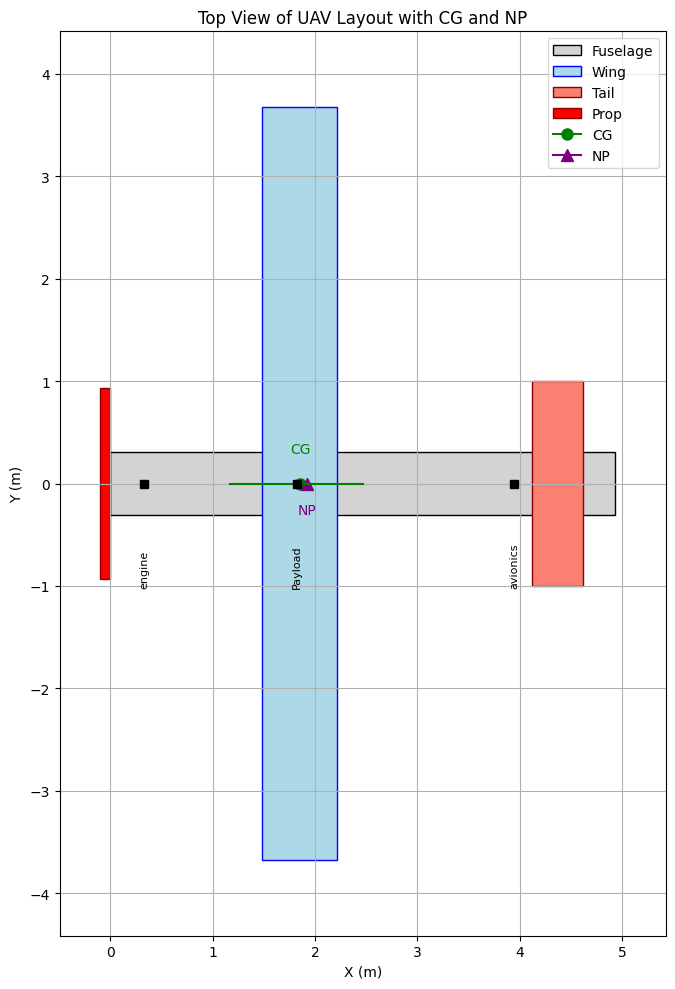

In [53]:


# components, components_z = estimate_component_positions(predrop, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)
components = x_positions
components = {"engine":components["engine"], "Payload":components["internal_payload"], "avionics":components["avionics"]}#, "wing_payload": components["wing_payload"]}

# components = {}

# h_tail_le_position = predrop["cruiseout_cg_from_nose_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
# h_tail_le_position = predrop["x_ht_le_m"]
# h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]

plot_uav_top_view(
    fuselage_length=predrop["fuselage_body_length_m"],
    fuselage_width=predrop["fuselage_body_width_m"],
    wing_span=predrop["wing_span_m"],
    wing_chord=predrop["chord_m"],
    wing_le_position=predrop["wing_le_position_m"],
    tail_span=predrop["h_tail_span_m"],
    tail_chord=predrop["h_tail_chord_m"],
    tail_le_position=h_tail_le_position,
    components=components,
    cg_position=predrop["cruiseback_cg_from_nose_m"],
    np_position=predrop["neutral_point_m"],
)



In [113]:
predrop["cruiseout_cg_from_nose_m"], x_positions["internal_payload"]

(2.35255699026381, 2.3519912930402285)

In [13]:
baseline_eval = evaluate_fuel_variant_with_to(
    predrop,             # current_values dictionary (cur)
    assumed_and_set,
    hard_constraints,
    weights_dict_kg_no_fuel,
    deflections_dict,
)

In [22]:
baseline_eval.keys()

dict_keys(['fuel_capacity_kg', 'fuel_loaded_kg', 'fuel_capped', 'tank_capacity', 'takeoff', 'phase', 'mission_times_hr', 'post_mission_fuel_kg', 'max_endurance_loiter_hr', 'max_range_cruise_km', 'power_caps'])

In [202]:
time_to_alt = time_to_altitude(
    predrop, assumed_and_set, engine_specs, propeller_specs, deflections_dict,
    wing_area_m2 = predrop["wing_area_m2"],
    alt_start_m = 0, alt_end_m = hard_constraints["cruise_altitude_m"],
    speed_mode="best",   # "best" or "given"
    speed_kmh_given=None,
    config="clean",
    flap_deflection_deg=0, flap_span_fraction=0.50, spanwise_flap_effectiveness=0.95,
    oswald_e=0.85,
    steps=40
)

In [203]:
time_to_alt["time_mins"]

7.564295770491691

In [ ]:
time_to_alt["profile"]

({'h_mid_m': 37.5,
  'ROC_ms': 6.432481515097074,
  'V_used_kmh': 138.58795683146076},)

In [ ]:
pd.DataFrame(time_to_alt["profile"])

In [ ]:
import numpy as np

# ---------- Helpers ----------

def _aileron_C_l_delta_from_wing_polars(deflections_dict, phase_key, alpha_w_deg, d_defl_fd_deg=5.0,
                                        aileron_span_fraction=0.45):
    """
    Airplane rolling-moment coefficient per rad of aileron, C_l_delta.
    Uses ±d_defl wing deflection tables at the SAME alpha to get sectional dCl/dδ,
    then applies rectangular-wing outer-span integration: span_factor = (2η - η^2).
    """
    key_m = f"{phase_key}_{int(-d_defl_fd_deg)}"
    key_p = f"{phase_key}_{int(+d_defl_fd_deg)}"
    if key_m not in deflections_dict or key_p not in deflections_dict:
        raise ValueError(f"Missing wing deflection tables ±{d_defl_fd_deg}° for phase '{phase_key}'.")
    sect_m = get_coefficients_at_alpha(deflections_dict[key_m], alpha_w_deg)
    sect_p = get_coefficients_at_alpha(deflections_dict[key_p], alpha_w_deg)
    dCl_sec = sect_p["CL"] - sect_m["CL"]
    ddelta_rad = np.deg2rad(2.0*d_defl_fd_deg)
    dCl_d_delta_sec = dCl_sec / max(ddelta_rad, 1e-6)  # sectional per rad

    eta = np.clip(float(aileron_span_fraction), 0.0, 1.0)
    span_factor = (2.0*eta - eta**2)                  # airplane integration for rectangular wing
    C_l_delta = dCl_d_delta_sec * span_factor         # airplane per rad
    return C_l_delta, dCl_d_delta_sec

def _rudder_Cn_delta_estimate(cur, assumed, hard, qt_over_q=1.0):
    """
    Rudder yawing-moment effectiveness per rad, Cn_delta_r (airplane),
    from vertical tail geometry & simple 2π-AR formula.
    If you already have a higher-fidelity Cn_delta_r, replace this.
    """
    # Geometry & ratios
    S  = cur["wing_area_m2"]
    b  = cur["wing_span_m"]
    Sv = cur["vertical_tail_area_m2"]
    lv = cur.get("tail_arm_m", 0.0)  # x-distance CG→VT AC; use your best estimate

    ARv   = assumed.get("AR_vertical", 2.0)
    tau_r = assumed.get("rudder_effectiveness_tau", 0.45)      # hinge effectiveness
    # Thin-airfoil tail lift curve slope (per rad), mildly 3D corrected
    a_v = 2.0*np.pi * ARv / (2.0 + np.sqrt(4.0 + ARv**2))      # per rad
    # Convert sectional tail lift to aircraft yawing moment:
    # Cn_delta_r ≈ (qt/q) * (Sv*lv)/(S*b) * a_v * tau_r
    Cn_delta_r = qt_over_q * (Sv * lv) / (S * b) * a_v * tau_r
    return Cn_delta_r

def _prop_yawing_moment_coeff(cur, hard, phase, prop_radius_m,
                              k_pfactor=0.7, k_swirl=0.2, prop_eta_for_thrust=0.80, alpha_disk_coeff=0.7):
    """
    Equivalent yawing-moment coefficient Cn_engine from P-factor + swirl.
    Uses a simple, tunable form:
      N_engine ≈ T * R_prop * (k_pfactor * alpha_disk + k_swirl)
      Cn_engine = N_engine / (q S b)
    T is estimated from shaft power and speed (P_shaft * ηprop / V).
    alpha_disk ≈ wing alpha (deg→rad) relative to prop axis.
    """
    # Environment
    rho = get_air_density(hard["cruise_altitude_m"] if (("cruise" in phase) or ("loiter" in phase)) else 0.0)
    V   = kmh_to_ms(cur[f"{phase}_speed_kmh"])
    q   = 0.5 * rho * V**2
    S   = cur["wing_area_m2"]
    b   = cur["wing_span_m"]

    # Thrust estimate from power and airspeed
    P_shaft = float(cur[f"{phase}_power_kw"]) * 1000.0      # W (shaft power)
    T_est   = (P_shaft * prop_eta_for_thrust) / max(V, 1.0) # N

    # Disk angle of attack ~ wing alpha (deg) - prop axis incidence (assume 0 unless you store it)
    alpha_w_deg = float(cur.get(f"{phase}_angle_of_attack_deg", 0.0))
    alpha_disk  = np.deg2rad(alpha_disk_coeff*alpha_w_deg)

    N_engine = T_est * prop_radius_m * (k_pfactor * alpha_disk + k_swirl)  # N·m
    Cn_engine = N_engine / max(q * S * b, 1e-6)
    return Cn_engine, {"T_est_N": T_est, "alpha_disk_deg": alpha_w_deg}

def _prop_roll_coeff_from_torque(cur, hard, phase):
    """
    Convert engine torque (shaft) to equivalent airplane rolling-moment coefficient C_l_engine.
    C_l_engine = Q / (q S b),  where Q = P_shaft / omega_prop.
    """
    rho = get_air_density(hard["cruise_altitude_m"] if (("cruise" in phase) or ("loiter" in phase)) else 0.0)
    V   = kmh_to_ms(cur[f"{phase}_speed_kmh"])
    q   = 0.5 * rho * V**2
    S   = cur["wing_area_m2"]; b = cur["wing_span_m"]

    P_w = float(cur[f"{phase}_power_kw"]) * 1000.0
    rpm = float(cur.get(f"{phase}_rpm", 4500.0))
    omega = 2.0*np.pi*rpm/60.0
    Q = P_w / max(omega, 1.0)
    C_l_engine = Q / max(q*S*b, 1e-6)
    return C_l_engine, {"Q_prop_Nm": Q}

def _phase_key(phase):
    return "cruise" if ("cruise" in phase or phase == "loiter") else "takeoff"

# ---------- Main solvers ----------

def yaw_roll_trim_coordinated(
    cur, assumed, hard, deflections_dict, phase,
    prop_radius_m,
    aileron_span_fraction=0.45, d_defl_fd_deg=5.0,
    aileron_limit_deg=20.0, rudder_limit_deg=25.0,
    include_prop_torque_in_roll=True,
    k_pfactor=1.0, k_swirl=0.3, prop_eta_for_thrust=0.80,
    Cl_phi_per_rad=0.0, bank_phi_deg=0.0
):
    """
    Solve δ_r (rudder) and δ_a (aileron) for coordinated flight (β = 0).
    Equations:
      Cn_total = Cn_delta_r*δr + Cn_engine = 0  -> δr
      Cl_total = Cl_delta*δa + Cl_phi*φ + Cl_engine = 0  -> δa
    """
    pk = _phase_key(phase)

    # Wing alpha
    alpha_w_deg = float(cur.get(f"{phase}_angle_of_attack_deg",
                                get_row_for_cl(deflections_dict[f"{pk}_0"], cur.get(f"{phase}_cl", 0.5))["alpha"]
                                - assumed.get("wing_incident_angle", 0.0)))

    # Aileron effectiveness
    C_l_delta, dCl_d_delta_sec = _aileron_C_l_delta_from_wing_polars(
        deflections_dict, pk, alpha_w_deg, d_defl_fd_deg, aileron_span_fraction
    )

    # Rudder effectiveness (airplane)
    qt_over_q = cur.get(f"{phase}_tail_dynamic_pressure_ratio", 1.0)
    Cn_delta_r = _rudder_Cn_delta_estimate(cur, assumed, hard, qt_over_q=qt_over_q)

    # Prop-induced yaw coefficient
    Cn_engine, yaw_info = _prop_yawing_moment_coeff(
        cur, hard, phase, prop_radius_m,
        k_pfactor=k_pfactor, k_swirl=k_swirl, prop_eta_for_thrust=prop_eta_for_thrust
    )

    # Rudder to cancel yaw (β=0)
    delta_r_rad = - Cn_engine / max(Cn_delta_r, 1e-6)
    delta_r_deg = np.rad2deg(delta_r_rad)

    # Roll terms
    Cl_engine, roll_info = _prop_roll_coeff_from_torque(cur, hard, phase) if include_prop_torque_in_roll else (0.0, {"Q_prop_Nm": 0.0})
    phi_rad = np.deg2rad(bank_phi_deg)

    # Aileron to cancel roll
    rhs_Cl = -(Cl_phi_per_rad * phi_rad + Cl_engine)
    delta_a_rad = rhs_Cl / max(C_l_delta, 1e-6)
    delta_a_deg = np.rad2deg(delta_a_rad)

    return {
        "mode": "coordinated_beta0",
        "alpha_w_deg": float(alpha_w_deg),
        "delta_rudder_deg": float(delta_r_deg),
        "delta_aileron_deg": float(delta_a_deg),
        "within_rudder_limit": abs(delta_r_deg) <= rudder_limit_deg,
        "within_aileron_limit": abs(delta_a_deg) <= aileron_limit_deg,
        "margins_deg": {
            "rudder": rudder_limit_deg - abs(delta_r_deg),
            "aileron": aileron_limit_deg - abs(delta_a_deg)
        },
        "coefficients": {
            "Cn_delta_r_per_rad": float(Cn_delta_r),
            "Cl_delta_a_per_rad": float(C_l_delta),
            "Cl_engine": float(Cl_engine),
            "Cn_engine": float(Cn_engine),
            "Cl_phi_per_rad": float(Cl_phi_per_rad)
        },
        "prop_yaw_info": yaw_info,
        "prop_roll_info": roll_info,
        "notes": f"Phase='{phase}', pk='{pk}', η_ail={aileron_span_fraction:.2f}, FD±{d_defl_fd_deg}°."
    }

def yaw_roll_trim_with_beta(
    cur, assumed, hard, deflections_dict, phase,
    prop_radius_m,
    beta_target_deg=0.0,                       # e.g., small nonzero β if desired
    aileron_span_fraction=0.45, d_defl_fd_deg=5.0,
    aileron_limit_deg=20.0, rudder_limit_deg=25.0,
    include_prop_torque_in_roll=True,
    k_pfactor=1.0, k_swirl=0.3, prop_eta_for_thrust=0.80,
    Cl_phi_per_rad=0.0, bank_phi_deg=0.0
):
    """
    Solve δr and δa with a prescribed β_target:
      Cn_beta*β + Cn_delta_r*δr + Cn_engine = 0
      Cl_beta*β + Cl_delta*δa + Cl_phi*φ + Cl_engine = 0
    """
    pk = _phase_key(phase)

    # Grab dihedral/keel derivatives if you already compute & store them
    Cn_beta = float(cur.get(f"{phase}_Cn_beta", 0.0))
    Cl_beta = float(cur.get(f"{phase}_Cl_beta", 0.0))

    alpha_w_deg = float(cur.get(f"{phase}_angle_of_attack_deg",
                                get_row_for_cl(deflections_dict[f"{pk}_0"], cur.get(f"{phase}_cl", 0.5))["alpha"]
                                - assumed.get("wing_incident_angle", 0.0)))

    C_l_delta, _ = _aileron_C_l_delta_from_wing_polars(
        deflections_dict, pk, alpha_w_deg, d_defl_fd_deg, aileron_span_fraction
    )
    qt_over_q = cur.get(f"{phase}_tail_dynamic_pressure_ratio", 1.0)
    Cn_delta_r = _rudder_Cn_delta_estimate(cur, assumed, hard, qt_over_q=qt_over_q)

    Cn_engine, yaw_info = _prop_yawing_moment_coeff(
        cur, hard, phase, prop_radius_m,
        k_pfactor=k_pfactor, k_swirl=k_swirl, prop_eta_for_thrust=prop_eta_for_thrust
    )
    Cl_engine, roll_info = _prop_roll_coeff_from_torque(cur, hard, phase) if include_prop_torque_in_roll else (0.0, {"Q_prop_Nm": 0.0})
    phi_rad = np.deg2rad(bank_phi_deg)
    beta_rad = np.deg2rad(beta_target_deg)

    # Solve 2x2 for [δr, δa] with β prescribed:
    # [ Cn_delta_r   0         ] [δr] = [ -Cn_engine - Cn_beta*β ]
    # [ 0            C_l_delta ] [δa]   [ -Cl_engine - Cl_beta*β - Cl_phi*φ ]
    rhs_yaw  = -(Cn_engine + Cn_beta * beta_rad)
    rhs_roll = -(Cl_engine + Cl_beta * beta_rad + Cl_phi_per_rad * phi_rad)

    delta_r_rad = rhs_yaw / max(Cn_delta_r, 1e-6)
    delta_a_rad = rhs_roll / max(C_l_delta, 1e-6)

    delta_r_deg = np.rad2deg(delta_r_rad)
    delta_a_deg = np.rad2deg(delta_a_rad)

    return {
        "mode": "prescribed_beta",
        "beta_target_deg": float(beta_target_deg),
        "alpha_w_deg": float(alpha_w_deg),
        "delta_rudder_deg": float(delta_r_deg),
        "delta_aileron_deg": float(delta_a_deg),
        "within_rudder_limit": abs(delta_r_deg) <= rudder_limit_deg,
        "within_aileron_limit": abs(delta_a_deg) <= aileron_limit_deg,
        "margins_deg": {
            "rudder": rudder_limit_deg - abs(delta_r_deg),
            "aileron": aileron_limit_deg - abs(delta_a_deg)
        },
        "coefficients": {
            "Cn_beta_per_rad": float(Cn_beta),
            "Cl_beta_per_rad": float(Cl_beta),
            "Cn_delta_r_per_rad": float(Cn_delta_r),
            "Cl_delta_a_per_rad": float(C_l_delta),
            "Cl_engine": float(Cl_engine),
            "Cn_engine": float(Cn_engine),
            "Cl_phi_per_rad": float(Cl_phi_per_rad)
        },
        "prop_yaw_info": yaw_info,
        "prop_roll_info": roll_info,
        "notes": f"Phase='{phase}', pk='{pk}', η_ail={aileron_span_fraction:.2f}, FD±{d_defl_fd_deg}°."
    }


In [217]:
yaw_roll_trim_coordinated(
    predrop, assumed_and_set, hard_constraints, deflections_dict,
    phase="takeoff",
    prop_radius_m=0.9,                # set your prop radius (m)
    aileron_span_fraction=0.45,
    k_pfactor=1.0, k_swirl=0.3,       # tune if you have data
    include_prop_torque_in_roll=True,
    Cl_phi_per_rad=0.0, bank_phi_deg=0.0
)


{'mode': 'coordinated_beta0',
 'alpha_w_deg': 15.0,
 'delta_rudder_deg': -13.80847618674931,
 'delta_aileron_deg': -0.12835247767420407,
 'within_rudder_limit': True,
 'within_aileron_limit': True,
 'margins_deg': {'rudder': 11.19152381325069, 'aileron': 19.871647522325794},
 'coefficients': {'Cn_delta_r_per_rad': 0.05849656724057365,
  'Cl_delta_a_per_rad': 1.2380787163974145,
  'Cl_engine': 0.002773510931446921,
  'Cn_engine': 0.014097870080703033,
  'Cl_phi_per_rad': 0.0},
 'prop_yaw_info': {'T_est_N': 1320.0, 'alpha_disk_deg': 15.0},
 'prop_roll_info': {'Q_prop_Nm': 131.30282805081367},
 'notes': "Phase='takeoff', pk='takeoff', η_ail=0.45, FD±5.0°."}

In [38]:
thrust_static_cap_factor = 0.8


cl_fraction_of_max = assumed_and_set["takeoff_cl_fraction_from_max"]
oswald_e_TO = assumed_and_set["oswald_derated"]

g = 9.81
rho = get_air_density(0)
W = predrop["mtow"] * g
m = W / g
ARw = float(assumed_and_set.get("aspect_ratio", 12.0))
mu_roll = float(assumed_and_set["rolling_resistance_coefficient"])

# Flap-effective CLmax and CD0
cl_pack = effective_CLmax_partial_span(
    deflections_dict, assumed_and_set, "takeoff", 0.0
)
cd0_pack = effective_CD0_partial_span(
    deflections_dict, assumed_and_set, "takeoff"
)

CLmax_eff = cl_pack["CLmax_eff"]

CD0_eff = cd0_pack["CD0_eff"]

# Induced factor
k_ind = 1.0 / (math.pi * ARw * oswald_e_TO)

# Power available (takeoff)
eta_prop_TO = propeller_specs["efficiency"].get("takeoff", propeller_specs["efficiency"].get("take-off", 0.75))
eta_gb = float(engine_specs.get("gear_box_efficiency", 1.0))
P_avail_W = float(engine_specs["max_power_kw"]) * 1000.0 * eta_prop_TO * eta_gb

s_target = float(hard_constraints["takeoff_distance_max_m"])

def ground_roll_for_S(Sw):
    # determine Vs with flaps for this S
    Vs = math.sqrt(W / (0.5 * rho * Sw * CLmax_eff))
    V_LOF = 1.2 * Vs

    # cap thrust near static using V_LOF
    T_cap = thrust_static_cap_factor * (P_avail_W / max(V_LOF, 1.0))

    # average CL during roll
    CL_avg = cl_fraction_of_max * CLmax_eff

    # integrate with fixed dt in speed domain (simple, robust)
    V = 0.1  # m/s to avoid div by zero
    x = 0.0
    dt = 0.05
    while V < V_LOF:
        q = 0.5 * rho * V**2
        L = q * Sw * CL_avg
        CD = CD0_eff + k_ind * (CL_avg**2)
        
        D = q * Sw * CD
        T = min(P_avail_W / max(V, 1.0), T_cap)
        Fx = (T - D - mu_roll * (W - L))

        if Fx <= 0.0:
            return math.inf, V_LOF  # infeasible
        a =  Fx / m
        
        a = max(a, 0.1)
        
        V += a * dt
        x += V * dt

        
    return x, V_LOF

In [57]:
target_distance = 100
starting_area = 5

ground_roll_for_S(predrop["wing_area_m2"])[0]

40.11533176623528

In [46]:
predrop['mtow']

196.5800261230436